In [1]:
import gzip
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-12 02:35:34.408779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 02:35:36.064946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-12 02:35:40.050985: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# 1. Read the Dataset

In [2]:
# Read the labels
labels = pd.read_csv("../data/data.info.labelled", sep=',')
labels.head()

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0
3,ENSG00000004059,ENST00000000233,332,0
4,ENSG00000004059,ENST00000000233,368,0


In [ ]:
# Read the data (as df)
file_path = "../data/dataset0.json.gz"
FEATURE_NAMES = ['dwell_-1','std_-1','mean_-1',
                 'dwell_0','std_0','mean_0',
                 'dwell_+1','std_+1','mean_+1']

def flatten_deep_data(file_path, estimated_rows=11000000):
    BATCH_SIZE = 10000
    GROWTH_FACTOR = 1.5
    
    # Pre-allocate arrays
    capacity = estimated_rows
    transcript_ids = np.empty(capacity, dtype=object)
    positions = np.empty(capacity, dtype=np.int32)
    seq = np.empty(capacity, dtype=object)
    feature_arrays = [np.empty(capacity, dtype=np.float32) for _ in range(9)]
    
    idx = 0
    batch_start = 0
    
    # Temporary batch storage
    batch_transcript_ids = []
    batch_positions = []
    batch_seq = []
    batch_features = [[] for _ in range(9)]
    
    def flush_batch():
        """Flush batch to main arrays"""
        nonlocal idx, batch_start, capacity
        
        batch_size = len(batch_transcript_ids)
        if batch_size == 0:
            return
        
        # Resize if needed
        while idx + batch_size > capacity:
            new_capacity = int(capacity * GROWTH_FACTOR)
            transcript_ids.resize(new_capacity, refcheck=False)
            positions.resize(new_capacity, refcheck=False)
            seq.resize(new_capacity, refcheck=False)
            for i in range(9):
                feature_arrays[i].resize(new_capacity, refcheck=False)
            capacity = new_capacity
        
        # Bulk assignment
        transcript_ids[idx:idx+batch_size] = batch_transcript_ids
        positions[idx:idx+batch_size] = batch_positions
        seq[idx:idx+batch_size] = batch_seq
        for i in range(9):
            feature_arrays[i][idx:idx+batch_size] = batch_features[i]
        
        idx += batch_size
        
        # Clear batch
        batch_transcript_ids.clear()
        batch_positions.clear()
        batch_seq.clear()
        for lst in batch_features:
            lst.clear()
    
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            for transcript_id, positions_dict in data.items():
                for transcript_position, sequences in positions_dict.items():
                    pos_int = int(transcript_position)
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            # Add to batch
                            batch_transcript_ids.append(transcript_id)
                            batch_positions.append(pos_int)
                            batch_seq.append(sequence)
                            for i, val in enumerate(features):
                                batch_features[i].append(val)
                            
                            # Flush when batch is full
                            if len(batch_transcript_ids) >= BATCH_SIZE:
                                flush_batch()
                                
                                if idx % 100000 == 0:
                                    print(f"Processed {idx:,} rows...", end='\r')
    
    # Flush remaining batch
    flush_batch()
    
    print(f"\nCreating DataFrame with {idx:,} rows...")
    
    # Trim and create DataFrame
    df = pd.DataFrame({
        'transcript_id': transcript_ids[:idx],
        'transcript_position': positions[:idx],
        'sequence': seq[:idx],
        'dwell_-1': feature_arrays[0][:idx],
        'std_-1': feature_arrays[1][:idx],
        'mean_-1': feature_arrays[2][:idx],
        'dwell_0': feature_arrays[3][:idx],
        'std_0': feature_arrays[4][:idx],
        'mean_0': feature_arrays[5][:idx],
        'dwell_+1': feature_arrays[6][:idx],
        'std_+1': feature_arrays[7][:idx],
        'mean_+1': feature_arrays[8][:idx],
    })
    
    return df

df = flatten_deep_data(file_path)

# Add gene_id from labels to df
df = pd.merge(df, labels, on=['transcript_id', 'transcript_position'], how='left')
df = df.drop(columns=['label'])
cols = ['gene_id'] + [col for col in df.columns if col != 'gene_id']
df = df[cols]
df.head()

Processed 11,000,000 rows...
Creating DataFrame with 11,027,106 rows...


,gene_id,transcript_id,transcript_position,sequence,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,mean_+1
0,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.099998
1,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.900002
2,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.599998
3,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.400002
4,ENSG00000004059,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.199997


In [4]:
# Analyse the structure of reads
print("Total number of rows in dataset:", len(df))
print("\nUnique (transcript_id, transcript_position) combinations:", 
      df.groupby(['transcript_id', 'transcript_position']).ngroups)

# Check how many reads per position
reads_per_position = df.groupby(['transcript_id', 'transcript_position']).size()
print(f"\nReads per position statistics:")
print(f"Mean: {reads_per_position.mean():.2f}")
print(f"Median: {reads_per_position.median():.2f}")
print(f"Min: {reads_per_position.min()}")
print(f"Max: {reads_per_position.max()}")
print(f"Std: {reads_per_position.std():.2f}")

# Show examples of multiple reads for same position
print(f"\nExample of multiple reads for same position:")
example_group = df.groupby(['transcript_id', 'transcript_position']).get_group(
    df.groupby(['transcript_id', 'transcript_position']).size().idxmax()
)
print(example_group[['transcript_id', 'transcript_position', 'sequence', 'dwell_0', 'std_0', 'mean_0']].head(10))

Total number of rows in dataset: 11027106

Unique (transcript_id, transcript_position) combinations: 121838

Reads per position statistics:
Mean: 90.51
Median: 47.00
Min: 20
Max: 991
Std: 137.33

Example of multiple reads for same position:
           transcript_id  transcript_position sequence  dwell_0  std_0  \
2376782  ENST00000278572                  559  TTAACTA  0.00266   0.95   
2376783  ENST00000278572                  559  TTAACTA  0.00512   2.42   
2376784  ENST00000278572                  559  TTAACTA  0.01100   3.00   
2376785  ENST00000278572                  559  TTAACTA  0.00796   2.56   
2376786  ENST00000278572                  559  TTAACTA  0.00398   3.29   
2376787  ENST00000278572                  559  TTAACTA  0.01130   3.38   
2376788  ENST00000278572                  559  TTAACTA  0.01760   2.11   
2376789  ENST00000278572                  559  TTAACTA  0.00624   2.18   
2376790  ENST00000278572                  559  TTAACTA  0.01260   2.53   
2376791  ENST000002

# 2. Feature Extraction

In [5]:
# Create aggregated features dataset for CNN with spatial organisation + sequence encoding
def create_cnn_features(group):
    """Create aggregated features for each (transcript_id, transcript_position)
    organised by position for CNN spatial structure with sequence one-hot encoding"""
    features = {}
    
    # Define positions and their feature types
    positions = ['-1', '0', '+1']
    feature_types = ['dwell', 'std', 'mean']
    
    # 1. ORIGINAL SIGNAL FEATURES (preserving spatial organization)
    for pos in positions:
        for feat_type in feature_types:
            col = f'{feat_type}_{pos}'
            # Create all 9 statistics for this feature at this position
            features[f'{col}_mean'] = group[col].mean()
            features[f'{col}_median'] = group[col].median()
            features[f'{col}_std'] = group[col].std()
            features[f'{col}_iqr'] = group[col].quantile(0.75) - group[col].quantile(0.25)
            features[f'{col}_skew'] = group[col].skew()
            features[f'{col}_min'] = group[col].min()
            features[f'{col}_max'] = group[col].max()
            features[f'{col}_q25'] = group[col].quantile(0.25)
            features[f'{col}_q75'] = group[col].quantile(0.75)
    
    # 2. SEQUENCE ONE-HOT ENCODING (spatially organized by position)
    # Get consensus sequence for this position (should be same for all reads)
    consensus_sequence = group['sequence'].iloc[0]  # 7-mer sequence
    nucleotides = ['A', 'C', 'G', 'T']
    
    # One-hot encode using OVERLAPPING 5-mers - sliding window approach
    # SLIDING WINDOW: Each CNN position gets 5 consecutive nucleotides with overlap
    # seq_idx:  0   1   2   3   4   5   6
    # pos:     -3  -2  -1   0  +1  +2  +3
    # 5-mers:  [----Position -1----]       <- chars 1-5: indices 0,1,2,3,4
    #            [----Position 0-----]     <- chars 2-6: indices 1,2,3,4,5  
    #              [----Position +1----]   <- chars 3-7: indices 2,3,4,5,6
    
    # Define 5-mer windows for each CNN position
    cnn_position_windows = {
        '-1': [0, 1, 2, 3, 4],  # Characters 1-5 (indices 0-4)
        '0':  [1, 2, 3, 4, 5],  # Characters 2-6 (indices 1-5)
        '+1': [2, 3, 4, 5, 6]   # Characters 3-7 (indices 2-6)
    }
    
    # For each CNN position, create one-hot features for the 5-mer window
    for pos in positions:
        # Get sequence indices for this CNN position's 5-mer window
        seq_indices = cnn_position_windows[pos]
        
        for seq_idx in seq_indices:
            if seq_idx < len(consensus_sequence):
                nucleotide = consensus_sequence[seq_idx]
                seq_pos_label = seq_idx - 3  # Convert to relative position (-3 to +3)
                
                # Create one-hot encoding for this sequence position
                for nt in nucleotides:
                    features[f'seq_pos{seq_pos_label}_{nt}_{pos}'] = 1 if nucleotide == nt else 0
    
    # 3. ADDITIONAL SEQUENCE FEATURES (organized by CNN position using 5-mer windows)
    # BALANCED: Each position gets composition features for their 5-mer window
    for pos in positions:
        seq_indices = cnn_position_windows[pos]
        
        # Count nucleotides for this CNN position's 5-mer window
        pos_sequence = ''.join([consensus_sequence[i] for i in seq_indices if i < len(consensus_sequence)])
        
        for nt in nucleotides:
            features[f'nt_count_{nt}_{pos}'] = pos_sequence.count(nt)
            features[f'nt_freq_{nt}_{pos}'] = pos_sequence.count(nt) / len(pos_sequence) if pos_sequence else 0
        
        # Purine/Pyrimidine for this position's 5-mer
        purines = sum(1 for n in pos_sequence if n in ['A', 'G'])
        features[f'purine_count_{pos}'] = purines
        features[f'purine_freq_{pos}'] = purines / len(pos_sequence) if pos_sequence else 0
    
    return pd.Series(features)

tqdm.pandas()

print("Creating aggregated features for CNN...")
cnn_features = df.groupby(['transcript_id', 'transcript_position']).progress_apply(create_cnn_features, include_groups=False)
print(f"CNN feature matrix shape: {cnn_features.shape}")
print(f"Features per position: {cnn_features.shape[1]}")

Creating aggregated features for CNN...


100%|██████████| 121838/121838 [41:54<00:00, 48.45it/s] 

CNN feature matrix shape: (121838, 171)
Features per position: 171


In [6]:
# Test the enhanced feature extraction with one-hot encoding
print("🧪 Testing enhanced CNN features with sequence one-hot encoding...")

# Test with a small sample
sample_group = df.groupby(['transcript_id', 'transcript_position']).get_group(
    df.groupby(['transcript_id', 'transcript_position']).size().index[0]
)

print(f"Sample group shape: {sample_group.shape}")
print(f"Sample sequence: {sample_group['sequence'].iloc[0]}")

# Test the enhanced function
enhanced_features = create_cnn_features(sample_group)
print(f"\nEnhanced features count: {len(enhanced_features)}")

# Categorize features
signal_features = [f for f in enhanced_features.index if any(x in f for x in ['mean', 'median', 'std', 'iqr', 'skew', 'min', 'max', 'q25', 'q75'])]
sequence_features = [f for f in enhanced_features.index if 'seq_pos' in f]
nucleotide_features = [f for f in enhanced_features.index if any(x in f for x in ['nt_count', 'nt_freq', 'purine'])]

print(f"\nFeature breakdown:")
print(f"  Signal features: {len(signal_features)} (original 9 stats × 3 positions × 3 feature types)")
print(f"  One-hot sequence features: {len(sequence_features)} (nucleotide encoding per position)")
print(f"  Nucleotide composition features: {len(nucleotide_features)} (counts and frequencies)")
print(f"  Total: {len(enhanced_features)}")

# Show sample features from each category
print(f"\nSample signal features: {signal_features[:3]}")
print(f"Sample sequence features: {sequence_features[:5]}")
print(f"Sample composition features: {nucleotide_features[:3]}")

# Count features per CNN position
pos_minus1 = [f for f in enhanced_features.index if '_-1' in f]
pos_0 = [f for f in enhanced_features.index if '_0' in f and '_-1' not in f and '_+1' not in f]
pos_plus1 = [f for f in enhanced_features.index if '_+1' in f]

print(f"\nFeatures per CNN position:")
print(f"  Position -1: {len(pos_minus1)}")
print(f"  Position 0: {len(pos_0)}")
print(f"  Position +1: {len(pos_plus1)}")

# Check if features are balanced
if len(pos_minus1) == len(pos_0) == len(pos_plus1):
    print("✅ Features are perfectly balanced across CNN positions!")
    features_per_position = len(pos_minus1)
    print(f"   Features per position: {features_per_position}")
    print(f"   Expected CNN input shape: (3, {features_per_position})")
else:
    print("⚠️  Features are not evenly distributed across positions")
    print("   This may require adjusting the feature organization")

🧪 Testing enhanced CNN features with sequence one-hot encoding...
Sample group shape: (185, 13)
Sample sequence: AAGACCA

Enhanced features count: 171

Feature breakdown:
  Signal features: 81 (original 9 stats × 3 positions × 3 feature types)
  One-hot sequence features: 60 (nucleotide encoding per position)
  Nucleotide composition features: 30 (counts and frequencies)
  Total: 171

Sample signal features: ['dwell_-1_mean', 'dwell_-1_median', 'dwell_-1_std']
Sample sequence features: ['seq_pos-3_A_-1', 'seq_pos-3_C_-1', 'seq_pos-3_G_-1', 'seq_pos-3_T_-1', 'seq_pos-2_A_-1']
Sample composition features: ['nt_count_A_-1', 'nt_freq_A_-1', 'nt_count_C_-1']

Features per CNN position:
  Position -1: 57
  Position 0: 57
  Position +1: 57
✅ Features are perfectly balanced across CNN positions!
   Features per position: 57
   Expected CNN input shape: (3, 57)


# 3. Implement CNN

In [7]:
# Reshape and rescale features and create train/test split
def prepare_cnn_data(features_df, labels_df, gene_train_ids):
    """Prepare data with proper spatial organization for CNN"""
    
    # Verify we have the right number of features (now including sequence features)
    n_features = features_df.shape[1]
    print(f"Total features available: {n_features}")
    
    # Expected features: 81 original + sequence features
    # We'll calculate dynamically based on what we have
    
    # Organize features by position for proper CNN spatial structure
    feature_names = features_df.columns
    
    # Group ALL features by position (-1, 0, +1) - including signal and sequence features
    pos_minus1_features = [f for f in feature_names if '_-1' in f]
    pos_0_features = [f for f in feature_names if '_0' in f and '_-1' not in f and '_+1' not in f]  
    pos_plus1_features = [f for f in feature_names if '_+1' in f]
    
    print(f"Features per position: -1={len(pos_minus1_features)}, 0={len(pos_0_features)}, +1={len(pos_plus1_features)}")
    
    # Check that features are evenly distributed across positions
    if len(pos_minus1_features) != len(pos_0_features) or len(pos_0_features) != len(pos_plus1_features):
        print(f"Warning: Uneven feature distribution across positions!")
        print(f"Position -1 features: {len(pos_minus1_features)}")
        print(f"Position 0 features: {len(pos_0_features)}")  
        print(f"Position +1 features: {len(pos_plus1_features)}")
    
    features_per_position = len(pos_minus1_features)  # Should be same for all positions
    
    # Create properly ordered feature matrix: [position_-1_features, position_0_features, position_+1_features]
    ordered_features = pos_minus1_features + pos_0_features + pos_plus1_features
    feature_matrix = features_df[ordered_features].values
    
    # Reshape to (N_samples, 3_positions, features_per_position)
    feature_matrix = feature_matrix.reshape(-1, 3, features_per_position)
    print(f"Reshaped feature matrix: {feature_matrix.shape} (samples, positions, features_per_position)")
    
    # Get labels aligned with features
    y = labels_df.set_index(['transcript_id', 'transcript_position']).loc[features_df.index]['label'].values
    gene_mapping = labels_df.set_index(['transcript_id', 'transcript_position']).loc[features_df.index]['gene_id'].values
    
    # Single train/test split
    train_mask = np.isin(gene_mapping, gene_train_ids)
    
    X_train, X_test = feature_matrix[train_mask], feature_matrix[~train_mask]
    y_train, y_test = y[train_mask], y[~train_mask]
    
    # Scale features (reshape to 2D, scale, reshape back)
    scaler = StandardScaler()
    
    # Fit on training data: reshape, scale, reshape back
    original_train_shape = X_train.shape
    original_test_shape = X_test.shape
    
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, features_per_position)).reshape(original_train_shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, features_per_position)).reshape(original_test_shape)
    
    print(f"Scaling completed. Final shapes:")
    print(f"X_train: {X_train_scaled.shape} (samples, positions, features_per_position)")
    print(f"X_test: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, train_mask

# Split into 80-20 train-test based on gene_id
gene_ids = labels['gene_id'].unique()
training_n = int(0.8 * len(gene_ids))
gene_train = np.random.choice(gene_ids, size=training_n, replace=False)
X_train, X_test, y_train, y_test, train_mask = prepare_cnn_data(
    cnn_features, labels, gene_train
)
test_mask = ~train_mask

print(f"\nFinal data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Total features available: 171
Features per position: -1=57, 0=57, +1=57
Reshaped feature matrix: (121838, 3, 57) (samples, positions, features_per_position)
Scaling completed. Final shapes:
X_train: (98459, 3, 57) (samples, positions, features_per_position)
X_test: (23379, 3, 57)

Final data shapes:
X_train: (98459, 3, 57), y_train: (98459,)
X_test: (23379, 3, 57), y_test: (23379,)
Training class distribution: [94036  4423]
Test class distribution: [22327  1052]


In [8]:
# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.5235175890084648), 1: np.float64(11.130341397241692)}


In [9]:
# Create validation split from training data
cnn_gene_mapping = labels.set_index(['transcript_id', 'transcript_position']).loc[cnn_features.index]['gene_id'].values
train_genes = np.unique(cnn_gene_mapping[train_mask])
val_size = int(0.2 * len(train_genes))
val_genes = np.random.choice(train_genes, size=val_size, replace=False)

val_mask = np.isin(cnn_gene_mapping[train_mask], val_genes)
train_final_mask = ~val_mask

X_train_final = X_train[train_final_mask]
X_val = X_train[val_mask]
y_train_final = y_train[train_final_mask]
y_val = y_train[val_mask]

print(f"Final training set: {X_train_final.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Training callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_pr_auc', 
        patience=10, 
        restore_best_weights=True,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_pr_auc',
        save_best_only=True,
        mode='max'
    )
]

Final training set: 78056 samples
Validation set: 20403 samples
Test set: 23379 samples


In [10]:
# Cross-validation with gene-level splits
def create_cnn(input_shape=(3, 'auto'), num_classes=1):
    """
    Improved CNN with better architecture and regularization
    """
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        
        # More sophisticated conv layers
        keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        
        # Attention mechanism (simple)
        keras.layers.GlobalAveragePooling1D(),
        
        # More dense layers with residual connection concept
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

def cross_validate_model(X_train, y_train, gene_mapping, n_folds=5):
    """
    Perform gene-level cross-validation
    """
    # Set up group k-fold based on genes
    gkf = GroupKFold(n_splits=n_folds)
    
    cv_scores = {
        'accuracy': [], 'precision': [], 'recall': [], 
        'roc_auc': [], 'pr_auc': [], 'f1': []
    }
    
    fold = 1
    for train_idx, val_idx in gkf.split(X_train, y_train, groups=gene_mapping):
        print(f"\n🔄 Training Fold {fold}/{n_folds}")
        
        # Split data
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Create and compile model
        model = create_cnn(input_shape=(X_train.shape[1], X_train.shape[2]))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc'),
                keras.metrics.AUC(name='pr_auc', curve='PR')
            ]
        )
        
        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_pr_auc', patience=15, restore_best_weights=True, mode='max'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=8, min_lr=1e-7, mode='max')
        ]
        
        # Train
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=100,  # Increased with early stopping
            batch_size=128,  # Smaller batch size
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=0
        )
        
        # Evaluate
        scores = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        y_pred = model.predict(X_fold_val, verbose=0)
        
        # Calculate F1 score
        from sklearn.metrics import f1_score
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_fold_val, y_pred_binary)
        
        # Store scores
        cv_scores['accuracy'].append(scores[1])
        cv_scores['precision'].append(scores[2])
        cv_scores['recall'].append(scores[3])
        cv_scores['roc_auc'].append(scores[4])
        cv_scores['pr_auc'].append(scores[5])
        cv_scores['f1'].append(f1)
        
        print(f"Fold {fold} - PR AUC: {scores[5]:.4f}, F1: {f1:.4f}")
        fold += 1
    
    # Print summary
    print(f"\n📊 Cross-Validation Results (Mean ± Std):")
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_scores

# Run cross-validation
print("Starting cross-validation...")
cv_results = cross_validate_model(
    X_train, y_train, 
    cnn_gene_mapping[train_mask], 
    n_folds=5
)

Starting cross-validation...

🔄 Training Fold 1/5


2025-10-12 03:18:33.957880: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Fold 1 - PR AUC: 0.5068, F1: 0.4048

🔄 Training Fold 2/5
Fold 2 - PR AUC: 0.5134, F1: 0.3768

🔄 Training Fold 3/5
Fold 3 - PR AUC: 0.4818, F1: 0.3314

🔄 Training Fold 4/5
Fold 4 - PR AUC: 0.4878, F1: 0.3856

🔄 Training Fold 5/5
Fold 5 - PR AUC: 0.4706, F1: 0.3725

📊 Cross-Validation Results (Mean ± Std):
ACCURACY: 0.8734 ± 0.0157
PRECISION: 0.2416 ± 0.0206
RECALL: 0.8355 ± 0.0123
ROC_AUC: 0.9245 ± 0.0021
PR_AUC: 0.4921 ± 0.0159
F1: 0.3742 ± 0.0241


In [ ]:
# Hyperparameter optimisation with Keras Tuner
def build_tunable_model(hp):
    """
    Build model with hyperparameters to tune
    """
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(3, X_train_final.shape[2])))
    
    # Tune number of conv layers
    for i in range(hp.Int('num_conv_layers', 2, 4)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', values=[3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(hp.Float(f'conv_{i}_dropout', 0.1, 0.5, step=0.1)))
    
    # Global pooling
    if hp.Choice('pooling', ['avg', 'max']) == 'avg':
        model.add(keras.layers.GlobalAveragePooling1D())
    else:
        model.add(keras.layers.GlobalMaxPooling1D())
    
    # Tune dense layers
    for i in range(hp.Int('num_dense_layers', 2, 4)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(hp.Float(f'dense_{i}_dropout', 0.1, 0.5, step=0.1)))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Tune optimiser
    learning_rate = hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='pr_auc', curve='PR')]
    )
    
    return model

tuner = kt.RandomSearch(
   build_tunable_model,
    objective=kt.Objective('val_pr_auc', direction='max'),
    max_trials=20,
    directory='tuning_results',
    project_name='cnn_m6a'
)

tuner.search(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)]
)

best_model = tuner.get_best_models()[0]

Trial 20 Complete [00h 09m 19s]
val_pr_auc: 0.49236780405044556

Best val_pr_auc So Far: 0.5060848593711853
Total elapsed time: 03h 31m 35s


/home/ubuntu/miniconda/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training CNN model for evaluation and plotting...
Epoch 1/50
607/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6518 - auc: 0.7369 - loss: 0.6176 - pr_auc: 0.1243 - precision: 0.0851 - recall: 0.6990

610/610 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7070 - auc: 0.8129 - loss: 0.5316 - pr_auc: 0.1834 - precision: 0.1065 - recall: 0.7716 - val_accuracy: 0.7967 - val_auc: 0.8817 - val_loss: 0.4189 - val_pr_auc: 0.3837 - val_precision: 0.1732 - val_recall: 0.8211 - learning_rate: 0.0010
Epoch 2/50
607/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8001 - auc: 0.8781 - loss: 0.4399 - pr_auc: 0.2920 - precision: 0.1575 - recall: 0.8131

610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8023 - auc: 0.8839 - loss: 0.4277 - pr_auc: 0.3074 - precision: 0.1588 - recall: 0.8200 - val_accuracy: 0.7950 - val_auc: 0.8957 - val_loss: 0.4154 - val_pr_auc: 0.4205 - val_precision: 0.1748 - val_recall: 0.8419 - learning_rate: 0.0010
Epoch 3/50
608/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8080 - auc: 0.8950 - loss: 0.4089 - pr_auc: 0.3219 - precision: 0.1660 - recall: 0.8338

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8110 - auc: 0.8970 - loss: 0.4041 - pr_auc: 0.3261 - precision: 0.1669 - recall: 0.8332 - val_accuracy: 0.8129 - val_auc: 0.9029 - val_loss: 0.3803 - val_pr_auc: 0.4298 - val_precision: 0.1907 - val_recall: 0.8547 - learning_rate: 0.0010
Epoch 4/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8130 - auc: 0.8989 - loss: 0.4021 - pr_auc: 0.3470 - precision: 0.1697 - recall: 0.8331

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8172 - auc: 0.9030 - loss: 0.3923 - pr_auc: 0.3486 - precision: 0.1731 - recall: 0.8423 - val_accuracy: 0.8238 - val_auc: 0.9057 - val_loss: 0.3626 - val_pr_auc: 0.4476 - val_precision: 0.2004 - val_recall: 0.8538 - learning_rate: 0.0010
Epoch 5/50
606/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8273 - auc: 0.9061 - loss: 0.3883 - pr_auc: 0.3638 - precision: 0.1841 - recall: 0.8501

610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8313 - auc: 0.9103 - loss: 0.3779 - pr_auc: 0.3719 - precision: 0.1866 - recall: 0.8519 - val_accuracy: 0.8476 - val_auc: 0.9067 - val_loss: 0.3391 - val_pr_auc: 0.4597 - val_precision: 0.2212 - val_recall: 0.8221 - learning_rate: 0.0010
Epoch 6/50
609/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8369 - auc: 0.9105 - loss: 0.3794 - pr_auc: 0.3768 - precision: 0.1928 - recall: 0.8472

610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8391 - auc: 0.9121 - loss: 0.3740 - pr_auc: 0.3838 - precision: 0.1931 - recall: 0.8432 - val_accuracy: 0.8507 - val_auc: 0.9066 - val_loss: 0.3377 - val_pr_auc: 0.4606 - val_precision: 0.2246 - val_recall: 0.8202 - learning_rate: 0.0010
Epoch 7/50
606/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8381 - auc: 0.9151 - loss: 0.3693 - pr_auc: 0.3863 - precision: 0.1940 - recall: 0.8476

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8392 - auc: 0.9170 - loss: 0.3636 - pr_auc: 0.3920 - precision: 0.1940 - recall: 0.8496 - val_accuracy: 0.8511 - val_auc: 0.9118 - val_loss: 0.3409 - val_pr_auc: 0.4643 - val_precision: 0.2277 - val_recall: 0.8370 - learning_rate: 0.0010
Epoch 8/50
607/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8383 - auc: 0.9185 - loss: 0.3613 - pr_auc: 0.3995 - precision: 0.1951 - recall: 0.8539

610/610 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8406 - auc: 0.9196 - loss: 0.3580 - pr_auc: 0.3997 - precision: 0.1962 - recall: 0.8549 - val_accuracy: 0.8749 - val_auc: 0.9125 - val_loss: 0.3025 - val_pr_auc: 0.4711 - val_precision: 0.2588 - val_recall: 0.8172 - learning_rate: 0.0010
Epoch 9/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8474 - auc: 0.9219 - loss: 0.3520 - pr_auc: 0.4085 - precision: 0.2039 - recall: 0.8578 - val_accuracy: 0.8611 - val_auc: 0.9103 - val_loss: 0.3144 - val_pr_auc: 0.4673 - val_precision: 0.2368 - val_recall: 0.8093 - learning_rate: 0.0010
Epoch 10/50
609/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8384 - auc: 0.9223 - loss: 0.3522 - pr_auc: 0.4000 - precision: 0.1954 - recall: 0.8549

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8395 - auc: 0.9228 - loss: 0.3499 - pr_auc: 0.4027 - precision: 0.1960 - recall: 0.8610 - val_accuracy: 0.8597 - val_auc: 0.9127 - val_loss: 0.3080 - val_pr_auc: 0.4795 - val_precision: 0.2357 - val_recall: 0.8152 - learning_rate: 0.0010
Epoch 11/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8457 - auc: 0.9235 - loss: 0.3482 - pr_auc: 0.4090 - precision: 0.2032 - recall: 0.8663 - val_accuracy: 0.8810 - val_auc: 0.9099 - val_loss: 0.2801 - val_pr_auc: 0.4679 - val_precision: 0.2638 - val_recall: 0.7806 - learning_rate: 0.0010
Epoch 12/50
606/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8520 - auc: 0.9256 - loss: 0.3441 - pr_auc: 0.4105 - precision: 0.2123 - recall: 0.8707

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8516 - auc: 0.9268 - loss: 0.3412 - pr_auc: 0.4107 - precision: 0.2096 - recall: 0.8651 - val_accuracy: 0.8826 - val_auc: 0.9134 - val_loss: 0.2857 - val_pr_auc: 0.4825 - val_precision: 0.2703 - val_recall: 0.8043 - learning_rate: 0.0010
Epoch 13/50
607/610 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8607 - auc: 0.9284 - loss: 0.3368 - pr_auc: 0.4173 - precision: 0.2219 - recall: 0.8611

610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8576 - auc: 0.9282 - loss: 0.3371 - pr_auc: 0.4130 - precision: 0.2163 - recall: 0.8605 - val_accuracy: 0.8775 - val_auc: 0.9139 - val_loss: 0.3020 - val_pr_auc: 0.4864 - val_precision: 0.2615 - val_recall: 0.8053 - learning_rate: 0.0010
Epoch 14/50
607/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8568 - auc: 0.9286 - loss: 0.3369 - pr_auc: 0.4226 - precision: 0.2173 - recall: 0.8636

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8545 - auc: 0.9300 - loss: 0.3326 - pr_auc: 0.4295 - precision: 0.2139 - recall: 0.8704 - val_accuracy: 0.8686 - val_auc: 0.9151 - val_loss: 0.2979 - val_pr_auc: 0.4886 - val_precision: 0.2497 - val_recall: 0.8221 - learning_rate: 0.0010
Epoch 15/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8547 - auc: 0.9309 - loss: 0.3303 - pr_auc: 0.4197 - precision: 0.2137 - recall: 0.8678 - val_accuracy: 0.8471 - val_auc: 0.9114 - val_loss: 0.3271 - val_pr_auc: 0.4771 - val_precision: 0.2218 - val_recall: 0.8300 - learning_rate: 0.0010
Epoch 16/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8565 - auc: 0.9321 - loss: 0.3269 - pr_auc: 0.4305 - precision: 0.2167 - recall: 0.8736 - val_accuracy: 0.8716 - val_auc: 0.9133 - val_loss: 0.2926 - val_pr_auc: 0.4808 - val_precision: 0.2537 - val_recall: 0.8182 - learning_rate: 0.0010
Epoch 17/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8639 - auc: 0.9329 - loss:

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8635 - auc: 0.9401 - loss: 0.3061 - pr_auc: 0.4501 - precision: 0.2276 - recall: 0.8871 - val_accuracy: 0.8634 - val_auc: 0.9190 - val_loss: 0.3004 - val_pr_auc: 0.4967 - val_precision: 0.2434 - val_recall: 0.8320 - learning_rate: 5.0000e-04
Epoch 21/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8654 - auc: 0.9425 - loss: 0.2992 - pr_auc: 0.4619 - precision: 0.2303 - recall: 0.8883 - val_accuracy: 0.8775 - val_auc: 0.9171 - val_loss: 0.2791 - val_pr_auc: 0.4888 - val_precision: 0.2639 - val_recall: 0.8211 - learning_rate: 5.0000e-04
Epoch 22/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8648 - auc: 0.9431 - loss: 0.2980 - pr_auc: 0.4614 - precision: 0.2300 - recall: 0.8912 - val_accuracy: 0.8607 - val_auc: 0.9167 - val_loss: 0.3101 - val_pr_auc: 0.4891 - val_precision: 0.2395 - val_recall: 0.8310 - learning_rate: 5.0000e-04
Epoch 23/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8689 - auc: 0.

610/610 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8686 - auc: 0.9493 - loss: 0.2784 - pr_auc: 0.4730 - precision: 0.2368 - recall: 0.9021 - val_accuracy: 0.8737 - val_auc: 0.9169 - val_loss: 0.2870 - val_pr_auc: 0.4987 - val_precision: 0.2588 - val_recall: 0.8291 - learning_rate: 2.5000e-04
Epoch 27/50
609/610 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8693 - auc: 0.9494 - loss: 0.2797 - pr_auc: 0.4730 - precision: 0.2410 - recall: 0.9146

610/610 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8700 - auc: 0.9499 - loss: 0.2777 - pr_auc: 0.4786 - precision: 0.2399 - recall: 0.9106 - val_accuracy: 0.8773 - val_auc: 0.9161 - val_loss: 0.2843 - val_pr_auc: 0.4995 - val_precision: 0.2641 - val_recall: 0.8251 - learning_rate: 2.5000e-04
Epoch 28/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8700 - auc: 0.9499 - loss: 0.2781 - pr_auc: 0.4788 - precision: 0.2411 - recall: 0.9084

610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8706 - auc: 0.9510 - loss: 0.2737 - pr_auc: 0.4798 - precision: 0.2401 - recall: 0.9059 - val_accuracy: 0.8774 - val_auc: 0.9153 - val_loss: 0.2834 - val_pr_auc: 0.5016 - val_precision: 0.2642 - val_recall: 0.8241 - learning_rate: 2.5000e-04
Epoch 29/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8746 - auc: 0.9500 - loss: 0.2768 - pr_auc: 0.4777 - precision: 0.2459 - recall: 0.9053 - val_accuracy: 0.8763 - val_auc: 0.9161 - val_loss: 0.2900 - val_pr_auc: 0.5001 - val_precision: 0.2618 - val_recall: 0.8211 - learning_rate: 2.5000e-04
Epoch 30/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8706 - auc: 0.9510 - loss: 0.2726 - pr_auc: 0.4748 - precision: 0.2408 - recall: 0.9109 - val_accuracy: 0.8649 - val_auc: 0.9165 - val_loss: 0.3064 - val_pr_auc: 0.4976 - val_precision: 0.2470 - val_recall: 0.8409 - learning_rate: 2.5000e-04
Epoch 31/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8731 - auc: 0.

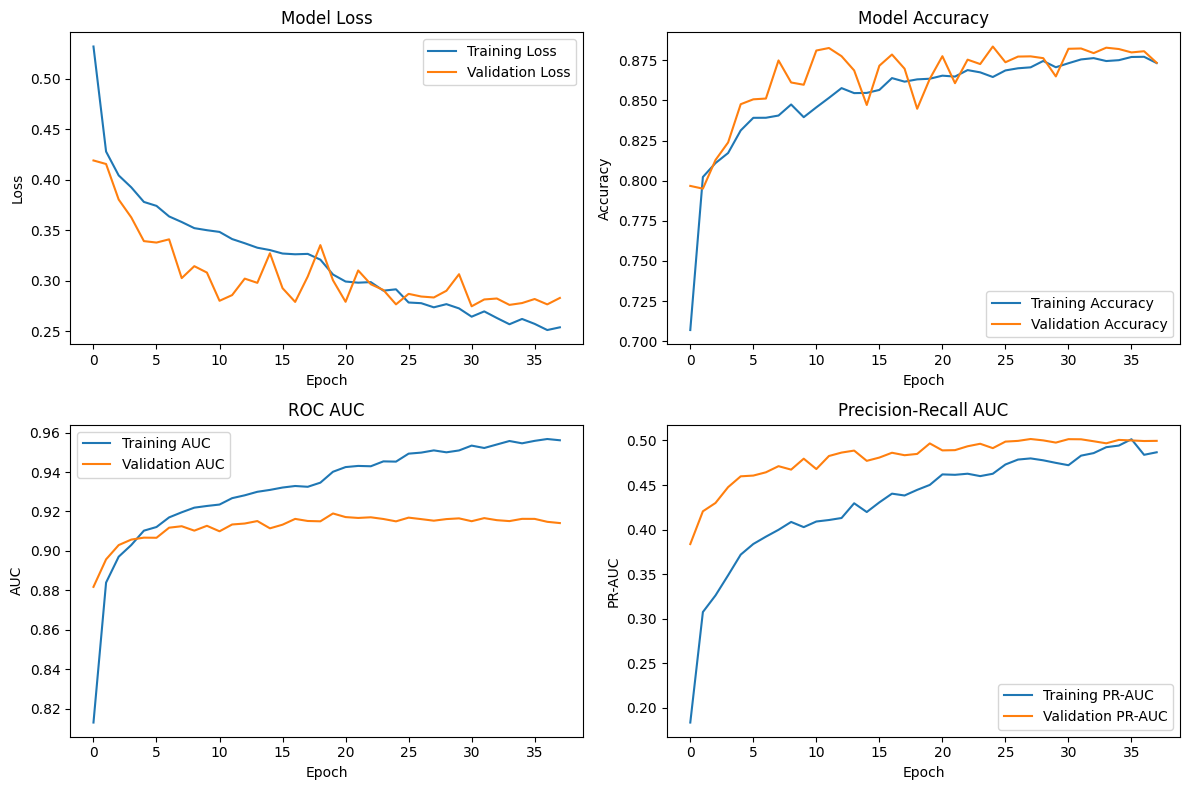


Test Set Performance:
Accuracy: 0.8773
Precision: 0.2414
Recall: 0.8061
ROC AUC: 0.9079
PR AUC: 0.4708

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     22327
           1       0.24      0.81      0.37      1052

    accuracy                           0.88     23379
   macro avg       0.62      0.84      0.65     23379
weighted avg       0.96      0.88      0.91     23379


Confusion Matrix:
[[19662  2665]
 [  204   848]]


In [12]:
# Train and evaluate the CNN model
print("Training CNN model for evaluation and plotting...")

# Create and compile the model
model = create_cnn(input_shape=(X_train_final.shape[1], X_train_final.shape[2]))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)

# Train the model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loss
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()

# ROC AUC
axes[1,0].plot(history.history['auc'], label='Training AUC')
axes[1,0].plot(history.history['val_auc'], label='Validation AUC')
axes[1,0].set_title('ROC AUC')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('AUC')
axes[1,0].legend()

# PR AUC
axes[1,1].plot(history.history['pr_auc'], label='Training PR-AUC')
axes[1,1].plot(history.history['val_pr_auc'], label='Validation PR-AUC')
axes[1,1].set_title('Precision-Recall AUC')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('PR-AUC')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc, test_pr_auc = model.evaluate(
    X_test, y_test, verbose=0
)

print(f"\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"ROC AUC: {test_auc:.4f}")
print(f"PR AUC: {test_pr_auc:.4f}")

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Additional metrics

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [13]:
# Create submission file
print("Creating submission file...")

# Get test data indices for submission
test_indices = cnn_features.index[test_mask]
test_transcript_ids = [idx[0] for idx in test_indices]
test_positions = [idx[1] for idx in test_indices]

# Create submission dataframe
submission_df = pd.DataFrame({
    'transcript_id': test_transcript_ids,
    'transcript_position': test_positions,
    'score': y_pred_proba.flatten()
})

# Save submission file
submission_df.to_csv('../predictions/dataset0_predictions_cnn.csv', index=False)
print(f"Submission file saved: ../predictions/dataset0_predictions_cnn.csv")
print(f"Shape: {submission_df.shape}")
print(f"Sample predictions:")
print(submission_df.head(10))

# Summary statistics
print(f"\nPrediction Statistics:")
print(f"Mean score: {submission_df['score'].mean():.4f}")
print(f"Std score: {submission_df['score'].std():.4f}")
print(f"Min score: {submission_df['score'].min():.4f}")
print(f"Max score: {submission_df['score'].max():.4f}")
print(f"Predicted positives (>0.5): {(submission_df['score'] > 0.5).sum()}")

Creating submission file...
Submission file saved: ../predictions/dataset0_predictions_cnn.csv
Shape: (23379, 3)
Sample predictions:
     transcript_id  transcript_position         score
0  ENST00000000412                  355  4.171520e-01
1  ENST00000000412                  367  2.712142e-02
2  ENST00000000412                  496  4.099036e-02
3  ENST00000000412                  501  1.676633e-01
4  ENST00000000412                  547  4.434213e-03
5  ENST00000000412                  559  1.098049e-03
6  ENST00000000412                  627  4.779119e-07
7  ENST00000000412                  674  1.263146e-03
8  ENST00000000412                  769  5.902629e-05
9  ENST00000000412                  783  4.586229e-03

Prediction Statistics:
Mean score: 0.1747
Std score: 0.2847
Min score: 0.0000
Max score: 0.9952
Predicted positives (>0.5): 3513


In [23]:
# Save the final trained model to ../models directory
print("Saving final trained model to ../models/...")

# Create models directory if it doesn't exist
import os
os.makedirs('../models', exist_ok=True)

# Save in modern Keras format
model.save('../models/final_cnn_model.keras')
print("✅ Final model saved as: ../models/final_cnn_model.keras")

# Also save model weights separately (legacy compatibility)
model.save_weights('../models/final_cnn_weights.weights.h5')
print("✅ Model weights saved as: ../models/final_cnn_weights.weights.h5")

# Save in legacy format for compatibility
model.save('../models/final_cnn_model_legacy.h5')
print("✅ Legacy format saved as: ../models/final_cnn_model_legacy.h5")

# Summary of saved files
print(f"\n📁 Model Files Summary (saved to ../models/):")
print(f"  - best_cnn_model.keras: Best model during training (modern Keras format)")
print(f"  - final_cnn_model.keras: Final trained model (RECOMMENDED - modern format)")
print(f"  - final_cnn_model_legacy.h5: Final model (legacy HDF5 format for compatibility)")
print(f"  - final_cnn_weights.h5: Final model weights only (for loading into same architecture)")

print(f"\n💡 Usage recommendations:")
print(f"  • For new projects: Use ../models/final_cnn_model.keras")
print(f"  • For deployment: Use ../models/final_cnn_model.keras") 
print(f"  • For legacy systems: Use ../models/final_cnn_model_legacy.h5")

Saving final trained model to ../models/...
✅ Final model saved as: ../models/final_cnn_model.keras
✅ Model weights saved as: ../models/final_cnn_weights.weights.h5
✅ Legacy format saved as: ../models/final_cnn_model_legacy.h5

📁 Model Files Summary (saved to ../models/):
  - best_cnn_model.keras: Best model during training (modern Keras format)
  - final_cnn_model.keras: Final trained model (RECOMMENDED - modern format)
  - final_cnn_model_legacy.h5: Final model (legacy HDF5 format for compatibility)
  - final_cnn_weights.h5: Final model weights only (for loading into same architecture)

💡 Usage recommendations:
  • For new projects: Use ../models/final_cnn_model.keras
  • For deployment: Use ../models/final_cnn_model.keras
  • For legacy systems: Use ../models/final_cnn_model_legacy.h5
